IS6400 21/22 Semester B

- Week 7: Time Series (I)
    - Smoothing models

Zhiya Zuo (zhiyazuo@cityu.edu.hk)

Department of Information Systems

City University of Hong Kong

---

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as SP_STATS

In [2]:
import statsmodels.api as sm

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
#%matplotlib notebook

In [4]:
# if running in Google Colab, please run the following line
# !pip install --upgrade statsmodels

---

# Introduction

Forecasting inherently lives in human nature. As human beings, we either implicityly or explicitly think in a way to infer the future, which in turn guides our decision making. For example, weather forecasting is prevalent:
![img](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Newspaper_weather_forecast_-_today_and_tomorrow.svg/2560px-Newspaper_weather_forecast_-_today_and_tomorrow.svg.png)

In the business context, forecasting is commonly adopted across various scenarios. In finance, one usually find it important to make use of forecasting tools to help predict the future stock or cryptocurrency values to make profits. In operations management, it is critical to accurately manage inventory to avoid excessive storage cost due to misprediction of demand from the customers.

## Forecasting from a qualitative perspective

Notably, there are two general classes of forecasting approach. One is qualitative approach, which is often referred to as _judgemental forecasts_. As its name suggests, it relies on human judegement involving mental calculation using information which may be partially available or biased. Consequently, judgemental forecasts are highly subjective and may vary across individuals due to limits in both internal factors (e.g., cognitive limits) as well as external ones (e.g., political agendas).

One notable implementation of qualitative forecast is called the _delphi method_. In brief terms, it refers to an interative approach involving at least one faciliator recruiting domain experts for a few rounds of surveying and interviewing. The final forecast is then based on the average forecast generated from the iterative process.

![img](https://upload.wikimedia.org/wikipedia/commons/a/a4/Asking_the_crystal_orb.jpg)

Whereas the limits lying in this forecasting approach, it is inevitable in some cases where historical data available or suitable for quantitative analysis is unavailable. For instance, imagine that there is an academic department at CityU which is trying to design a new graduate program with a focus on _Smart Business and Financial Technology_. The critical issue is the design of a curriculum with courses covering appropriate topics involving technological as well as financial aspects to facilitate an interdisciplinary education outcome.
Therefore, this curriculum design can be framed as a forecasting task which involves an esitimate of the labor market demand in two to three years or even longer with respect to talent acquisition by businesses.

In this task, there is little historical data on smart business and financial technology. It is therefore essential for relevant panels with experts on this matter to pull together scattered and unstructured (and even noisy) information they have for discussion before a draft can be made.

Lastly, this forecasting approach is beyond the scope of this class. Next we move on to discuss on the other approach.

## Forecasting from a quantitative perspective

Whenever there is appropriate data source to solve a forecasting task, we may want to apply quantitative approaches to formulate such a problem using mathematical languages. 
To a large extent, extant data, especially well structured data, can provide significant amounts of signals to complement our qualitative assessment for a better prediction.

Under this quantitative perspective, there are two streams which can in fact be merged together:
1. Exponential smoothing methods that mine patterns from the past. The resulting patterns will then be exptrapolated into the future.
2. Regression methods that formulate forecasting as regression where the dependent variable is the future target of interest while the independent variable include both the past target and other relevant (causal) factors.

In the next section, we start with descriptive features of time series data, followed by discussion on the two approachs for quantitative forecasting.

---

# Time series data

In the previous class, we talk about predictive modelling in general. Given a set of training data, our goal is to predict the target of testing data. When one is exposed to prediction through classes on data mining, the dataset we are exposed to are oftentimes _cross sectional_ data, in which each row is about one record of an independent subject with each column being attributes about subjects.

Time series data is inherently different from cross sectional data given that it evolves over time. Rather than invovling multiple subjects, a time series data consists of repetitive measurement of a set of attributes (usually one) of a given subject over time. For instance, a time series dataset can be the daily temperature in Hong Kong or the daily stock closing price of Alibaba.
Note that when a dataset includes records including repetitive measurements over various subjects, it is referred to as a _panel_ dataset, which is beyond our scope.

How is time series analysis different from that with cross sectional data? Well, time series is complex due to its variety of patterns. To illustrate, we make use of a toy example below.

In [4]:
google_stock = pd.read_csv('Data/GOOG.csv', date_parser='Date')
google_stock.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-02-13,816.000000,820.958984,815.489990,819.239990,819.239990,1213300
1,2017-02-14,819.000000,823.000000,816.000000,820.450012,820.450012,1054700
2,2017-02-15,819.359985,823.000000,818.469971,818.979980,818.979980,1313600


The first thing we always want to do when we get a time series data is to visualize it. This is very helpful in facilitating our understanding about our data.

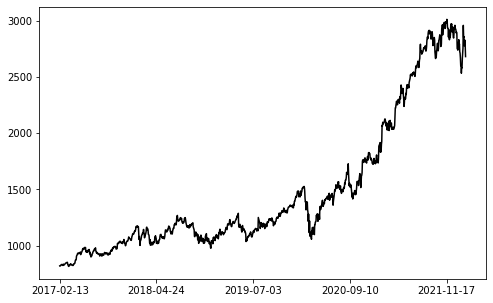

In [5]:
N_ticks = 5 # avoid tick labels being cluttered together
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(google_stock.Date, google_stock.Close, color='k')
_ = ax.xaxis.set_major_locator(plt.MaxNLocator(N_ticks))

A first intuition here is that it is going up in general. But what else should we try to capture? A good start is to statistically summarize the distribution of such time series:

In [6]:
google_stock.describe().round()

,Open,High,Low,Close,Adj Close,Volume
count,1260.0,1260.0,1260.0,1260.0,1260.0,1260.0
mean,1487.0,1502.0,1473.0,1488.0,1488.0,1563063.0
std,619.0,624.0,613.0,618.0,618.0,696063.0
min,807.0,821.0,803.0,814.0,814.0,346800.0
25%,1071.0,1082.0,1059.0,1071.0,1071.0,1114875.0
50%,1207.0,1220.0,1200.0,1209.0,1209.0,1388250.0
75%,1731.0,1749.0,1717.0,1736.0,1736.0,1778525.0
max,3037.0,3042.0,2998.0,3014.0,3014.0,6207000.0


The higher mean than the median hints on the skewed distribution of the change in Google' daily stock price over time.

## Autocorrelation

The term _autocorrelation_ may be familiar to us because of the existence of the word stem _correlation_.
Just as in the cross sectional case where we want to explore the correlation between variables, we could investigate to what extent a time series target varies over time.
In other terms, we can also compute the correlation between lagged time series data.
Formally, we can write the autocorrelation into the following form of autocorrelation function (ACF):

$$ r_k=\frac{\sum_{t=k+1}^{T} (y_t-\bar{y})(y_{t-k}-\bar{y})}{\sum_{t=1}^T(y_t-\bar{y})^2} $$

where $\bar{y}$ is the mean time series value; $T$ is the length of the time series. Intuitively, a small value of $k$ captures the correlation between adjacent time series values whereas a large one captures that between far apart time series values. To see what ACF really captures, let us try to compute the autocorrelation values using the Google daily stock data.

In [7]:
# k=1
lag = 1
r_1 = sm.tsa.stattools.acf(google_stock['Adj Close'], nlags=lag, fft=True)[1]
print('The autocorrelation with lag of %i is %.3f'%(lag, r_1))

The autocorrelation with lag of 1 is 0.997


This is a super high correlation - almost perfect autocorrelation, meaninig that it is very likely that the data is not generated from a random process. To more genearally capture this, we could run ACF with varying $k$ values:

In [8]:
lag = 10
r_1_to_10 = sm.tsa.stattools.acf(google_stock['Adj Close'], nlags=lag, fft=True)[1:]
print(pd.DataFrame({'Lag': np.arange(lag)+1, 'ACF': r_1_to_10}))

   Lag       ACF
0    1  0.997104
1    2  0.994140
2    3  0.990928
3    4  0.987910
4    5  0.984961
5    6  0.981861
6    7  0.978885
7    8  0.975501
8    9  0.972772
9   10  0.970041


A common practice is to visualize it. Luckily,`statsmodels` has this functionality shipped within the package to facilitate this:

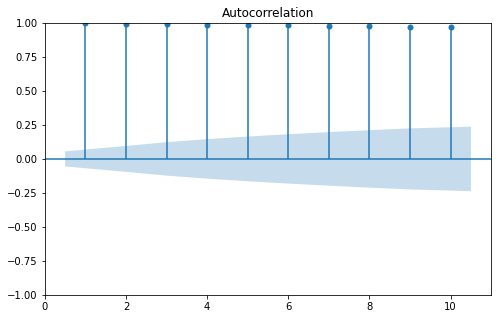

In [9]:
# the shaded region is the 95% CI
fig, ax = plt.subplots(figsize=[8, 5])
_ = sm.graphics.tsa.plot_acf(google_stock['Adj Close'], lags=lag, ax=ax, zero=False)

Usually the autocorrelation if we use more coarse-grained levels for capturing time series (or use a less frequently sampled time series)

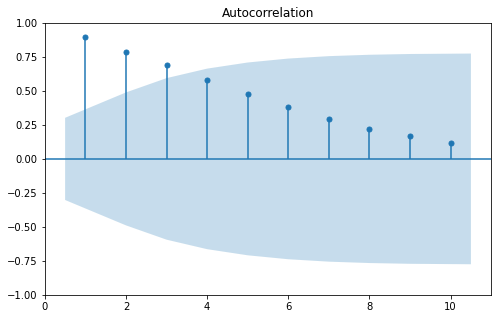

In [10]:
fig, ax = plt.subplots(figsize=[8, 5])
_ = sm.graphics.tsa.plot_acf(google_stock.loc[np.arange(0, google_stock.shape[0], 30), 'Adj Close'],
                             lags=lag, zero=False, ax=ax)

To see this more clearly, we can compare the above figures with one using random noise, in which the correlations fall within the confidence intervals:

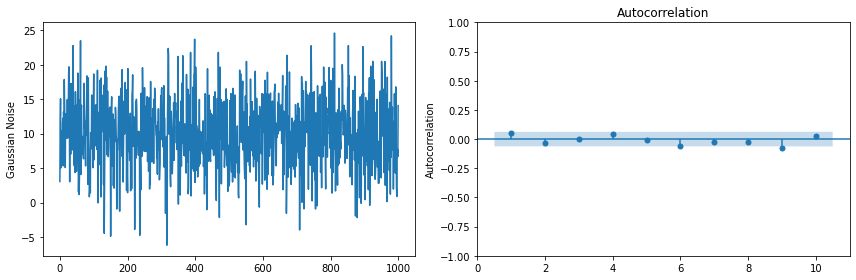

In [11]:
N_ts = 1000
random_ts = np.random.normal(loc=10, scale=5, size=N_ts) # standard normal
fig, (ax1, ax2) = plt.subplots(figsize=[12, 4], ncols=2)
ax1.plot(random_ts)
ax1.set_ylabel('Gaussian Noise')
sm.graphics.tsa.plot_acf(random_ts, lags=lag, ax=ax2, zero=False)
_ = ax2.set_ylabel('Autocorrelation')
fig.tight_layout()

## Stationarity

Time series data features many characteristics unavailable in cross sectional data. One key property is that whether the statistical charateristics of a time series depends on the observation time of its values.
In other words, we usually say that a time series in non-stationary if there are any patterns of trends or seasonalities. If we look at the time series of Google stock closing price, we can easily determine that it is not a stationary time series due to its clear upward trend over time.

Nonetheless, if we look at the _change_ of its closing price, we may see a different pattern:

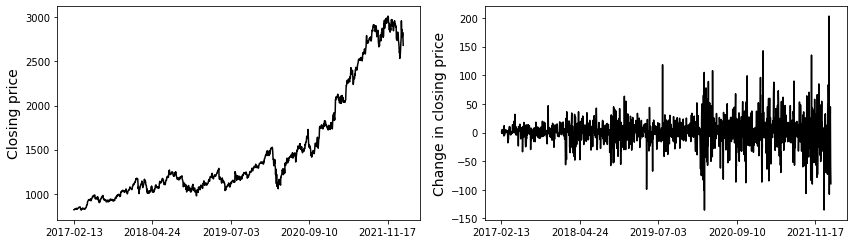

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize=[12, 3.5], ncols=2)
ax1.plot(google_stock.Date, google_stock.Close, color='k')
ax1.set_ylabel('Closing price', size=14)
ax2.plot(google_stock.Date.values, google_stock.Close.diff(1), color='k')
ax2.set_ylabel('Change in closing price', size=14)
_ = ax1.xaxis.set_major_locator(plt.MaxNLocator(N_ticks))
_ = ax2.xaxis.set_major_locator(plt.MaxNLocator(N_ticks))
fig.tight_layout()

Visually, we can tell that there is neither clear trend nor seasonality in the figure on the right, imply the stationarity of the closing price change. In fact, the Gaussian random noise we see above is also stationary.

In addition to check stationarity via graphs, we can also make use of statistical tests. One popular test is the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, whose null hypothesis ($H_o$) is that the input time series data is stationary. Let's apply that onto the two time series above:

In [13]:
kpss_closing_price = sm.tsa.stattools.kpss(google_stock['Close'], nlags='auto')
print('Google closing price stationarity p-value: %.3f'%kpss_closing_price[1])

Google closing price stationarity p-value: 0.010


/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [14]:
kpss_change_price = sm.tsa.stattools.kpss(google_stock['Close'].diff(1)[1:], nlags='auto')
print('Google closing price change stationarity p-value: %.3f'%kpss_change_price[1])

Google closing price change stationarity p-value: 0.100


/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Decomposition

As we can above in the stationarity example, time series data may or may not exhibit (explicit) patterns. Theoretically, statistians assume that a time series data can be decomposed into three components:
- Seasonality $S_t$
- Trend $T_t$
- Remainder (or randomness) $R_t$

Two common decompositions are often used:
- Additive decomposition. This form is appropriate to use when there is a relatively constant seasonality or trend (i.e., invariant as time goes by):
$$ y_t = S_t + T_t + R_t $$
- Multiplicative decomposition. This is to complement the shortcominings of additive decomposition such that when seasonality or trend is found to be proportional to time series levels, we may want to use this one.
$$ y_t = S_t \times T_t \times R_t $$

It is noteworthy that these two decompositions can actually be transformed from multiplicative to additive by taking the logarithm because:
$$ log(y_t) = log(S_t) + log(T_t) + log(R_t)$$

From the Google closing price data, we can see that there is varying trend over time since it is going faster in recent years. Therefore let's try apply multiplicative decomposition to the data using a commonly adopted approach named _Season-Trend decomposition using LOESS_ (STL):

In [15]:
closing_price = google_stock.set_index('Date')[['Close']].copy()
closing_price.index = pd.to_datetime(closing_price.index)
# aggregate the time series by month
closing_price = closing_price.resample('M').mean()

In [16]:
stl_decomp = sm.tsa.STL(closing_price).fit()
stl_trend = stl_decomp.trend
stl_seasonal = stl_decomp.seasonal
stl_resid= stl_decomp.resid
stl_lines = {'Data': closing_price,
             'Seasonal': stl_seasonal,
             'Trend': stl_trend,
             'Remainder': stl_resid}

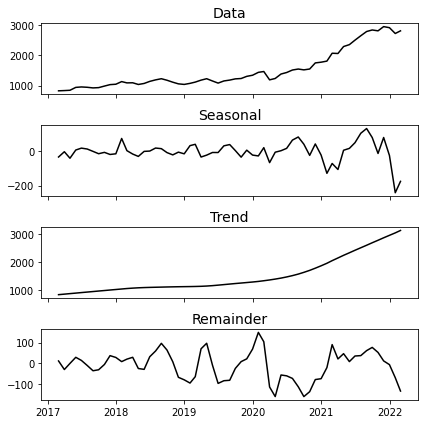

In [17]:
fig, ax_arr = plt.subplots(nrows=4, figsize=[6, 6], sharex=True, sharey=False)
for i, (y_lab, y_val) in enumerate(stl_lines.items()):
    ax = ax_arr.flat[i]
    ax.plot(y_val, color='k')
    ax.set_title(y_lab, size=14)
fig.tight_layout()

---

# Exponential smoothing models

## Intuition

After exploring some descriptive time series features, we now move on to discuss forecasting:
- __How can we predict the future target values based on historical patterns?__

From an intuitive perspective, we may argue that any change in the target value may relie on the current status. Maybe we can just have a rough estimate that the value at the next time step is essentially the current one:
$$ \hat{y_{t+1}} = y_t $$

While naive, this in fact aligns with how we may forecast in our daily lives - seeing that the Bitcoin price goes up today, we may conjecture that it may keep up with this upward trend on the next day.
In other words, we are extrapolating historical pattern by solely relying on the most recent observation but not any other samples in the distant past.
Hmm... Maybe this does not make sense. What should we do?

Aha! We could just aggregate more historical data. With a minor modification, we may have a slighly more complex model as:
$$ \hat{y_{t+1}} = \frac{\sum_{t=t_o}^T y_t}{T-t_o+1} $$

where $t_o$ is the most distant time series value we take into consideration for the next one. When $t_o=1$, this is equivalent to forecasting using the average of all previous data. This is commonly known as a naive approach

We may try this to see how well it performs. Let's say we try two different moving window lengths of 3 and 5, respectively:

In [18]:
closing_price = google_stock.set_index('Date')[['Close']].copy()
closing_price.index = pd.to_datetime(closing_price.index)
# aggregate the time series by month
closing_price = closing_price.resample('D').mean()

In [19]:
ma_windows = 3
closing_price_3 = [None] * ma_windows
for i in range(ma_windows, closing_price.size):
    closing_price_3.append(closing_price[i-ma_windows:i].mean())

In [20]:
ma_windows = 5
closing_price_5 = [None]*ma_windows + [closing_price[i-ma_windows:i].mean()\
                                       for i in range(ma_windows, closing_price.size)]

In [21]:
closing_price.size, len(closing_price_3), len(closing_price_5)

(1825, 1825, 1825)

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/numpy/ma/core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/numpy/ma/core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


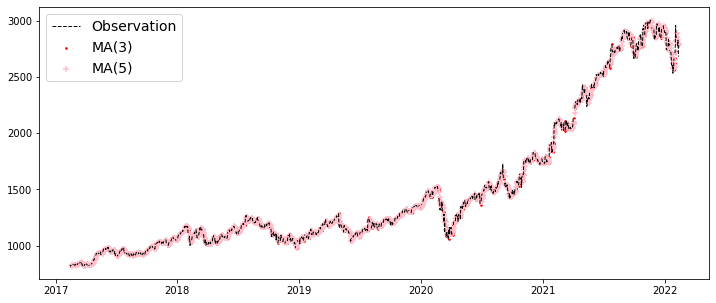

In [22]:
fig, ax = plt.subplots(figsize=[12, 5])
ax.plot(closing_price.index, closing_price.values,
        linestyle='--', linewidth=1,
        label='Observation', color='k')
ax.scatter(closing_price.index, closing_price_3,
           label='MA(3)', s=10, marker='.', color='r')
ax.scatter(closing_price.index, closing_price_5,
           label='MA(5)', s=30, marker='+', color='pink')
_ = ax.legend(prop={'size': 14})

To make it easier to see, let's use monthly closing price instead

In [23]:
closing_price.index = pd.to_datetime(closing_price.index)
closing_price_monthly = closing_price['Close'].resample('M').mean()
closing_price_monthly.head(2)

Date
2017-02-28    825.980003
2017-03-31    834.111307
Freq: M, Name: Close, dtype: float64

In [24]:
ma_windows = 3
closing_price_3 = [None] * ma_windows
for i in range(ma_windows, closing_price_monthly.size):
    closing_price_3.append(closing_price_monthly[i-ma_windows:i].mean())

In [25]:
ma_windows = 5
closing_price_5 = [None]*ma_windows + [closing_price_monthly[i-ma_windows:i].mean()\
                                       for i in range(ma_windows, closing_price_monthly.size)]

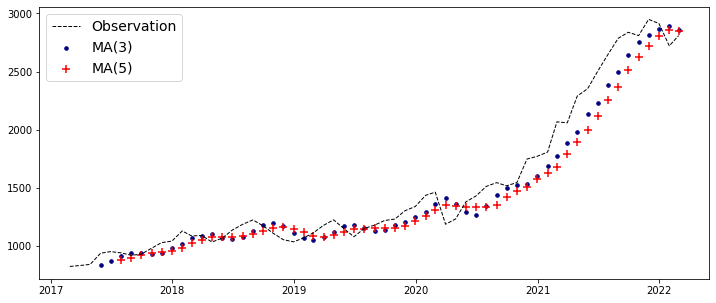

In [26]:
fig, ax = plt.subplots(figsize=[12, 5])
ax.plot(closing_price_monthly.index,
        closing_price_monthly.values,
        linestyle='--', linewidth=1,
        label='Observation', color='k')
ax.scatter(closing_price_monthly.index, closing_price_3,
           label='MA(3)', s=50, marker='.', color='navy')
ax.scatter(closing_price_monthly.index, closing_price_5,
           label='MA(5)', s=50, marker='+', color='red')
_ = ax.legend(prop={'size': 14})

Looking cool!

## Simple exponential smoothing

But another question is on identifying a proper way to weight the extent to which historical data at various time points should have on a future target. Our moving average approach is in effect a specific case which applies equal weights to each past data regardless how much they are far apart from the present within a given moving window.

Intuitively, we may want to place more emphasis on recent observations than those in the distant past. Based on this heuristics, we have the simple exponential smoothing model:

$$ \hat{y_{t+1}} =\alpha y_t + \alpha(1-\alpha)y_{t-1} + \alpha(1-\alpha)^2y_{t-2} + \ldots$$

where $\alpha$ is the smoothing parameter that controls time series weight. The larger it is, the faster the weight decays. To see this, we may come up with a table using various $\alpha$ values:

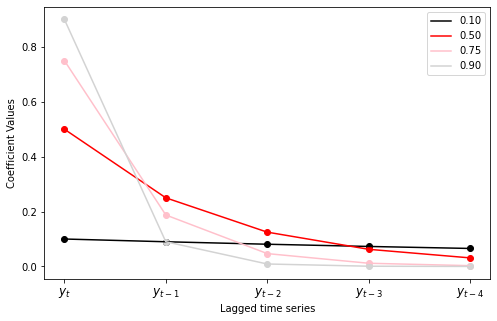

In [27]:
fig, ax = plt.subplots(figsize=[8, 5])
color_list = ['k', 'r', 'pink', 'lightgray']
for j, alpha in enumerate([0.1, 0.5, 0.75, 0.9]):
    alpha_list = list()
    for i in range(5): 
        coef_i = alpha*((1-alpha)**i)
        alpha_list.append(coef_i)
    ax.plot(range(5), alpha_list, label='%.2f'%alpha, color=color_list[j])
    ax.scatter(range(5), alpha_list, color=color_list[j])
ax.set_ylabel('Coefficient Values')
ax.set_xlabel('Lagged time series')
ax.set_xticks(range(5))
ax.set_xticklabels(['$y_t$'] + ['$y_{t-%i}$'%i for i in range(1,5)],
                   size=12)
ax.legend()

Sometimes you may encounter an alternative formulation of the simple exponential smoothing form known as the _component form_ which decomposes the model into two equations:
- Forecast equation: $\hat{y_{t+1}} = l_t$, which indicates that the forecast for time $t+1$ depends on the _level_ $l_t$ at time $t$....
- Smoothing (or level) equation: $l_t=\alpha y_t+ (1-\alpha)l_{t-1}$ which indicates that the level at time $t$ is proportional to the current observation as well as past levels; $\alpha$ is the smoothing parameter.

By iteratively inserting values into the forecast function, we eventually obtain the same equation as above:

$$
\begin{align}
\hat{y_{t+1}} &= \alpha y_t + (1-\alpha)l_{t-1}  \\
&= \alpha y_t + (1-\alpha)[\alpha y_{t-1} + (1-\alpha)l_{t-2}] \\
&= \alpha y_t + \alpha(1-\alpha)y_{t-1} + (1-\alpha)^2[\alpha y_{t-2} + (1-\alpha)l_{t-3}] \\
&= \ldots \\
&= \sum_{T} \alpha(1-\alpha)^{t-T} y_{T}
\end{align}
$$

How about we try it as well? Given the inclusion of this weight component $\alpha$, how would it be different? Let's try to make use of `statsmodels`'s `tsa` API to play with it:

As we shall see later, all the exponential smoothing models can be aggregated into a generalized time series model, the Error-Trend-Seasonality (ETS) model. In this example, we will directly use the `ETSModel` API from the `statsmodels`:

In [28]:
sim_exp = sm.tsa.ETSModel(closing_price_monthly, error='add')
sim_exp = sim_exp.fit(closing_price_monthly)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.92646D+00    |proj g|=  1.62537D-05

At iterate    1    f=  5.92646D+00    |proj g|=  1.62537D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      2      1     0     1   1.625D-05   5.926D+00
  F =   5.9264594789593597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [29]:
# the smoothing parameter: rapid decay
sim_exp.alpha

0.9999

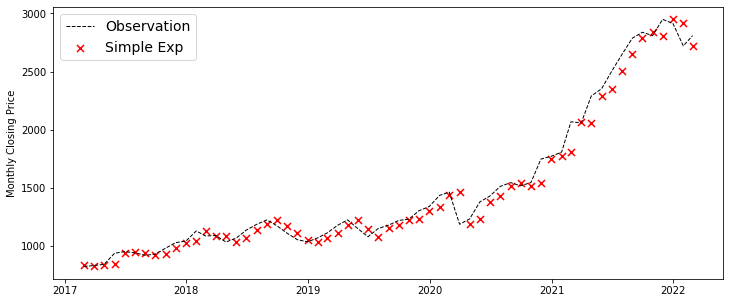

In [30]:
fig, ax = plt.subplots(figsize=[12, 5])
ax.plot(closing_price_monthly.index, closing_price_monthly.values,
        linestyle='--', linewidth=1,
        label='Observation', color='k')
ax.scatter(closing_price_monthly.index, sim_exp.fittedvalues,
           label='Simple Exp', s=50, marker='x', color='red')
ax.set_ylabel('Monthly Closing Price')
_ = ax.legend(prop={'size': 14})

## The drawback: Flat Prediction

Both naive approach simple exponential smoothing go beyond the naive approach, in which the forecast of any future values depend is estimated as the most recent observation. Nonethless, both forecasts still suffer from a critical issue: a flat forecast, i.e., the same prediction value no matter how far away we are looking into. 
Using mathematical language, we may formulate this as:

$$ \hat{y_{t+h}} = \hat{y_{t+1}};~~h\geq2$$

In other words, no matter how far away we are trying to look into, we are producing the same prediction value, i.e., the prediction on the next time step. This implies that such a forecast assumes a lack of trend or seasonality components in the given time series data.

## Captureing trends: Holt's method

What could we do to make the simple exponential model more useful such that it could be used to forecast future values? The statistician Charles Holt introduced an extention to incorporate the trend component into the model. Formally, a time series forecast model is formulated as:
- Forecast equation: $\hat{y_{t+h}} = l_t + hb_t$
- Smoothing (level) equation: $ l_t = \alpha y_t + (1-\alpha) (l_{t-1} + b_{t-1})$
- Trend equation: $b_t = \beta^{*}(l_t-l_{t-1}) + (1-\beta^{*})b_{t-1} $ 

where there are two new parameters: (i) $b_t$ denotes the changing trend or the slope and (ii) $\beta^{*}$ is the smoothing parameter for the temporal trend $b_t$. Recall that $\alpha$ is the smoothing parameter controlling how fast weight will decay into the past while $l_t$ is the time series level. While it looks strange at first sight, let's decompose the terms one by one to better understand it.

First, we may observe that the second term in the smoothing equation is $l_{t-1}+b_{t-1}=\hat{y_{t}}$ and thus:
$$ l_t=\alpha y_t +  (1-\alpha) \hat{y_t}$$
Thus the time series level $l_t$ is measured as the weighted average between the current observation and its predicted value using prior information up till time $t-1$.

Then we could proceed to investigate the trend component, which at the first sight is the weighted average between the current level change and the prior trend estimate:
$$ 
\begin{align}
b_t &=\beta^{*}(l_t-l_{t-1}) + (1-\beta^{*})[\beta^{*}(l_{t-1}-l_{t-2}) + (1-\beta^{*})b_{t-2}] \\
&= \beta^{*}(l_t-l_{t-1}) + \beta^{*}(1-\beta^{*})(l_{t-1}-l_{t-2}) + (1-\beta^{*})^2b_{t-2}
\end{align}
$$

Now let's stop... Hey! Isn't this just the same as the simple exponential smoothing? In other words, this model design estimates the trend component in a similar fashion as the exponential smoothing model on target forecasting without any trend:
$$ b_t= \sum_{T} \beta^{*}(1-\beta^{*})^{t-T} (l_{t-T} - l_{t-T-1}) $$

Now, because of the existence of the term $hb_t$, forecasts into the future will be changing rather than fixed. Specficially, it will grow linearly with a rate of $h$, which is the time units away from the current time step.

Let's see how it works out:

In [31]:
holt_exp = sm.tsa.ETSModel(closing_price_monthly, error='add', trend='add')
holt_exp = holt_exp.fit(closing_price_monthly, maxiter=1e5)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         2 variables are exactly at the bounds

At iterate    0    f=  6.54073D+00    |proj g|=  3.67651D-01

At iterate    1    f=  6.52040D+00    |proj g|=  5.66152D-02

At iterate    2    f=  6.51939D+00    |proj g|=  5.06357D-02

At iterate    3    f=  6.51302D+00    |proj g|=  6.82115D-02

At iterate    4    f=  6.51027D+00    |proj g|=  1.84561D-03

At iterate    5    f=  6.51018D+00    |proj g|=  6.34514D-04

At iterate    6    f=  6.51017D+00    |proj g|=  1.07585D-03

At iterate    7    f=  6.51008D+00    |proj g|=  7.85221D-03

At iterate    8    f=  6.50988D+00    |proj g|=  1.70311D-02

At iterate    9    f=  6.50933D+00    |proj g|=  3.26340D-02

At iterate   10    f=  6.50793D+00    |proj g|=  5.65475D-02

At iterate   11    f=  6.47469D+00    |proj g|=  4.56415D-02

At iterate   12    f=  6.27454D+00    |proj g|=  4.38774D-01

At iterate   13    f=  6.1

In [32]:
holt_exp.alpha, holt_exp.beta.round(6)

   5.856D+00
  F =   5.8564573880430579     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


(0.9999, 0.0001)

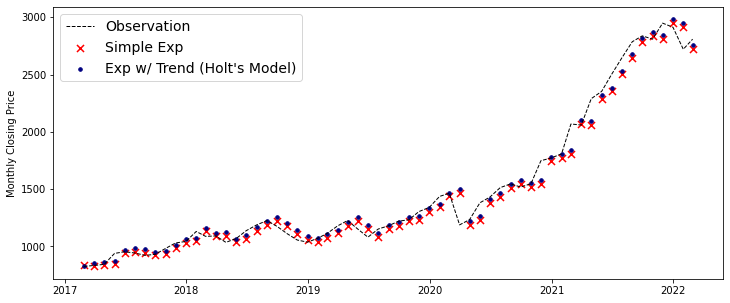

In [33]:
fig, ax = plt.subplots(figsize=[12, 5])
ax.plot(closing_price_monthly.index, closing_price_monthly.values,
        linestyle='--', linewidth=1,
        label='Observation', color='k')
ax.scatter(closing_price_monthly.index, sim_exp.fittedvalues,
           label='Simple Exp', s=50, marker='x', color='red')
ax.scatter(closing_price_monthly.index, holt_exp.fittedvalues,
           label='Exp w/ Trend (Holt\'s Model)', s=50, marker='.', color='navy')
ax.set_ylabel('Monthly Closing Price')
_ = ax.legend(prop={'size': 14})

Then you may ask - _Is it true that the trend is constant (fixed) over time_? Likely not. Both intuition and empirical evidence have found evidence that such a constant trend formulation of a forecasting model may unncessarily overestimate future trends.
A straightforward remedy then is to add another level of _decay_ nameas as a _damping parameter_ $\phi \in(0,1)$ on the trend component such that the three equations are changed into:
- Forecast equation: $\hat{y_{t+h}} = l_t + (\phi+\phi^2+\ldots+\phi^h)b_t$
- Smoothing (level) equation: $ l_t = \alpha y_t + (1-\alpha) (l_{t-1} + \phi b_{t-1})$
- Trend equation: $b_t = \beta^{*}(l_t-l_{t-1}) + (1-\beta^{*})\phi b_{t-1} $ 

If we set $\phi=1$, i.e., no damping on the trend constant at all, this is then equivalent to the same old Holt's model.
In addition, notice that as we move further into the future, we see that the trend effect will be decreased over time.

In [34]:
holt_exp_damped = sm.tsa.ETSModel(closing_price_monthly, error='add', trend='add', damped_trend=True)
holt_exp_damped = holt_exp_damped.fit(closing_price_monthly, maxiter=1e5, disp=False)

In [35]:
holt_exp_damped.alpha, holt_exp_damped.beta.round(6), holt_exp_damped.phi

(0.9999, 0.087511, 0.98)

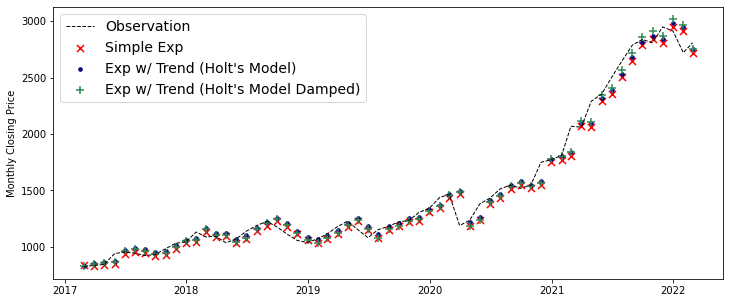

In [36]:
fig, ax = plt.subplots(figsize=[12, 5])
ax.plot(closing_price_monthly.index, closing_price_monthly.values,
        linestyle='--', linewidth=1,
        label='Observation', color='k')
ax.scatter(closing_price_monthly.index, sim_exp.fittedvalues,
           label='Simple Exp', s=50, marker='x', color='red')
ax.scatter(closing_price_monthly.index, holt_exp.fittedvalues,
           label='Exp w/ Trend (Holt\'s Model)', s=50, marker='.', color='navy')
ax.scatter(closing_price_monthly.index, holt_exp_damped.fittedvalues,
           label='Exp w/ Trend (Holt\'s Model Damped)', s=60, marker='+', color='SeaGreen')
ax.set_ylabel('Monthly Closing Price')
_ = ax.legend(prop={'size': 14})

## Trends + seasonality: Winter's method

What's next, you may ask. Can we add more components to the model? Recall that theoretically, a time series dataset can be decomposed into three components:(i) seasonality; (ii) trend; (iii) remainder (it could include both random noise and uncaptured residual due to model deficiency). Obviously, there is just this one thing we did not have - __seaonsality__.

And yes, as you may have already imaged, the way that we incorporte this model is to add another layer into our forecast framework.
Nonetheless, one cavaet needs to be noted before we try to introduce a seasonality into the model, which is the mechanism.
Recall that there are two types of time series decomposition: (i) additive and (ii) multiplicative, the choiec of which depends on how seasonality plays a role. 
Specifically, if the time series changes in a way that seasonality stays fixed over time, the former may be better and vice versa.
Consequently, we may introduce two formulations of an exponential smoothing method for both scenarios.
Note that seasonality refers to time series pattern within the _seasons_ of a year. If we foucs on quarters, we may set it to be $m=4$. Similarly, if we focus on monthly data, then $m=12$.

### Additive Form

When additive is deemd to be better, we write the extended model considering both trend and seasonality as:
- Forecast equation: $ \hat{y_{t+h}} =l_t + hb_t + s_{t+h-m} $
- Smoothing (level) equation: $l_t = \alpha(y_t - s_{t-m}) + (1-\alpha) (l_{t-1} + b_{t-1})$
- Trend equation: $b_t = \beta^{*}(l_t-l_{t-1}) + (1-\beta^{*}) b_{t-1} $
- Seasonality equation: $s_t = \gamma(y_t-l_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m}$

From the subscript of $s_{t+h-m}$, we may infer that this is referring to the seasonal component of the most recent time point (concerning the focal forecasting time point).
For myself, I find it not as intuitive at the beginning upon seeing these equations. Consequently, we may replace the letters by concrete numbers for a better understanding.

Now, let's say our data is at quarterly level such that every unit of $t$ is a quarter (i.e., 3 months). 
We will then set $m=4$ since 4 quarters make a year. Now let's assume that we are making one step ahead of time forecast -- $h=1$. Puttin all these into the equations above, we have (we're skipping the equation for the base level since it does not involve seasonality):
- Forecast equation: $ \hat{y_{t+1}} =l_t + b_t + s_{t-3} $
    - This is giving us clear evidence that the one-step ahead forecast $\hat{y_{t+1}}$ is the sum of the base level, the trend values of the most recent time point $t$ as well as that of the same seasonality which is at $t+1-4=t-3$.
- Smoothing (level) equation: $l_t = \alpha(y_t - s_{t-4}) + (1-\alpha) (l_{t-1} + b_{t-1})$
    - The second term $l_{t-1} + b_{t-1}=\hat{y_t}-s_{t-4}$ and thus $l_t = \alpha(y_t - s_{t-4}) + (1-\alpha)(\hat{y_t}-s_{t-4})$ such that the base is a weighted average of the de-seasoned observation and forecast at time $t$.
- Seasonality equation: $s_t = \gamma(y_t-l_{t-1}-b_{t-1}) + (1-\gamma)s_{t-4}$
    - The first term $y_t-l_{t-1}-b_{t-1}$=$y_t-(\hat{y_t}-s_{t-4})$ and thus $s_t = \gamma(y_t-\hat{y_t}+s_{t-4}) + (1-\gamma)s_{t-4}=\gamma(y_t-\hat{y_t})+s_{t-4}$, which is the sum of forecast error on time $t$ and the past season. A smaller $\gamma$ is equivalent to a more stable seasonality.

### Multiplicative Form

If we believe that the seasonality is varying over time, the additive form would be inappropriate. Rather than, we may adopt the second formulation by considering seasonality as a multiplicative term in the equations such that:

When additive is deemd to be better, we write the extended model considering both trend and seasonality as:
- Forecast equation: $ \hat{y_{t+h}} = (l_t + hb_t)s_{t+h-m} $
- Smoothing (level) equation: $l_t = \alpha \dfrac{y_t}{s_{t-m}} + (1-\alpha) (l_{t-1} + b_{t-1})$
- Trend equation: $b_t = \beta^{*}(l_t-l_{t-1}) + (1-\beta^{*}) b_{t-1} $
- Seasonality equation: $s_t = \gamma\dfrac{y_t}{l_{t-1}+b_{t-1}} + (1-\gamma)s_{t-m}$

It is noteworthy that the trend and seasonality components are incorporated into the equations under different mechanisms - the trend is modelled as additive while the seasonality as multiplicative.

### Examples

In [59]:
winter_exp_add = sm.tsa.ETSModel(closing_price_monthly, error='add',
                                 trend='add',damped_trend=True,
                                 seasonal='add', seasonal_periods=12)
winter_exp_add = winter_exp_add.fit(maxiter=1e5, disp=False)

In [60]:
winter_exp_add.gamma

9.999999999998898e-09

In [61]:
winter_exp_mul = sm.tsa.ETSModel(closing_price_monthly, error='add',
                                 trend='add', damped_trend=True,
                                 seasonal='mul', seasonal_periods=12)
winter_exp_mul = winter_exp_mul.fit(maxiter=1e5, disp=False)

In [62]:
winter_exp_mul.gamma

9.999999999998898e-09

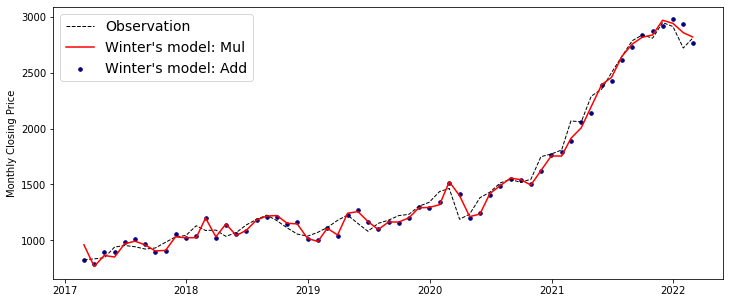

In [63]:
fig, ax = plt.subplots(figsize=[12, 5])
ax.plot(closing_price_monthly.index, closing_price_monthly.values,
        linestyle='--', linewidth=1,
        label='Observation', color='k')
ax.scatter(closing_price_monthly.index, winter_exp_add.fittedvalues,
           label='Winter\'s model: Add', s=50, marker='.', color='navy')
ax.plot(closing_price_monthly.index, winter_exp_mul.fittedvalues,
           label='Winter\'s model: Mul', color='r')
ax.set_ylabel('Monthly Closing Price')
_ = ax.legend(prop={'size': 14})

---

# Evaluation

So far we haven't really do any forecasting but just training (i.e. fitting the model) only. How do we properly evaluate the predictive performance?
Recall that in the previous week, we discuss the performance evaluation by partitioning our data into different folds such that one part of it can be used to tune the parameter while the remaining part is for investigation on whether the tuned parameter indeed makes satisfactory prediction.

Specifically, one commonly adopted approach is _cross validaion_, in which datasets are randomly split into equal size folds for training and testing respectively. This is perfectly fine in a cross sectional data where either there is no temporal order within the dataset or temporal order is meaningless for the given task. 
On the contrary, this does not hold in a time series forecasting task, which at its core is highly sensitive to the temporal sequences.

## Fixed partition

Well, if random participation does not work in time series, we can just split the data into a training and testing dataset with the former observed prior to the latter. In other words, an intuitive way is to force sampling "older" samples for the training set and more recent samples for the testing set. For instance, in the Google stock dataset, we could simply do:

In [42]:
# make sure that the dataset is ordered chronologically
closing_price_monthly.sort_index(inplace=True) 
closing_price_monthly.head()

Date
2017-02-28    825.980003
2017-03-31    834.111307
2017-04-30    844.056840
2017-05-31    939.284085
2017-06-30    953.766823
Freq: M, Name: Close, dtype: float64

We can then use the data with smaller indices as training set and those with larger indices as testing set. A commonly adopted ratio is 8:2.

In [43]:
closing_price_week = closing_price.resample('W').mean()['Close']
# if check any missing values
print('# of missing values: %i'%closing_price_week.isnull().sum())

# of missing values: 0


In [44]:
N_train = int(0.85 * closing_price_week.size)
N_test = closing_price_week.size - N_train
print('Training vs. testing: %i vs. %i'%(N_train, N_test))

Training vs. testing: 221 vs. 40


In [45]:
price_train = closing_price_week.iloc[:N_train]
price_test = closing_price_week.iloc[N_train:]
price_train.size, price_test.size

(221, 40)

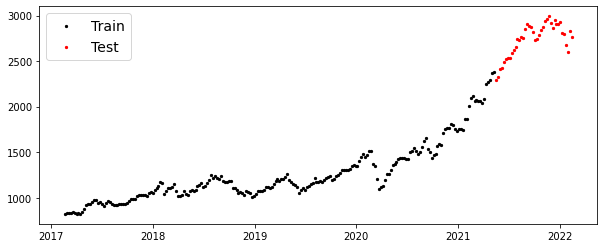

In [46]:
# visualize the training vs. test
fig, ax = plt.subplots(figsize=[10,4])
ax.scatter(price_train.index, price_train.values,
           marker='.', s=20,
           color='k', label='Train')
ax.scatter(price_test.index, price_test.values,
           marker='.', s=20,
           color='r', label='Test')
ax.legend(prop={'size': 14})

Let's run all the above models one this sequence and compare their _out-of-sample fit_ using mean squared errors:

In [47]:
# naive method: prediction using the last observation
price_pred_naive = pd.Series([price_train.values[-1]]*N_test,
                             index=price_test.index)

In [48]:
# simple exp smoothing: this is similar with the above naive methods 
# in that it produces the same forecasts no matter how far away 
# we want to look into
sim_exp = sm.tsa.ETSModel(price_train, error='add').fit(disp=False)
# use forecast method of the `ETSResults` object for out-of-sample forecasting
price_pred_sim = sim_exp.forecast(steps=N_test)

In [49]:
# Holt's method: exp smoothing w/ trend
holt_exp = sm.tsa.ETSModel(price_train, error='add', trend='mul').fit(disp=False)
price_pred_holt = holt_exp.forecast(steps=N_test)

In [51]:
# Holt-Winter's method: exp smoothing w/ trend and seasonality
winter_exp = sm.tsa.ETSModel(price_train, error='add',
                             trend='mul',seasonal='mul').fit(maxiter=200, disp=False)
price_pred_winter = winter_exp.forecast(steps=N_test)

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [52]:
pred_dict = {'Naive': price_pred_naive,
             'Simple': price_pred_sim,
             'Holt': price_pred_holt,
             'Winter': price_pred_winter,
            }

In [53]:
pred_args = {'Naive': dict(marker='.', color='pink', s=50),
             'Simple': dict(marker='.', color='navy', s=50),
             'Holt': dict(marker='.', color='orange', s=50),
             'Winter': dict(marker='.', color='darkgreen', s=50),
            }

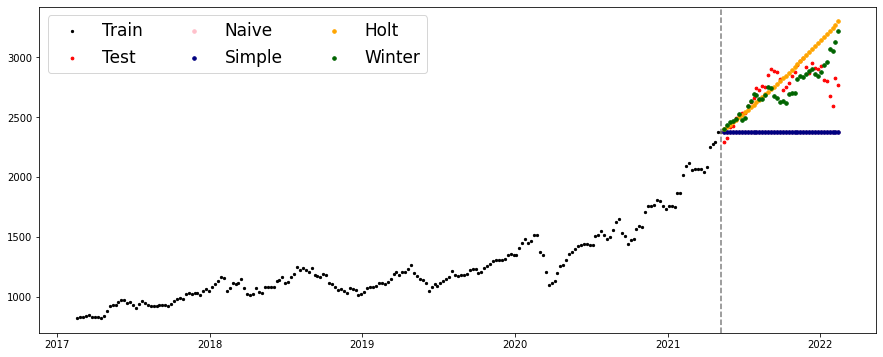

In [54]:
fig, ax = plt.subplots(figsize=[15, 6])
ax.scatter(price_train.index, price_train.values,
           marker='.', s=20,
           color='k', label='Train')
ax.scatter(price_test.index, price_test.values,
           marker='.', s=30,
           color='r', label='Test')
for mod, mod_pred in pred_dict.items():
    ax.scatter(price_test.index, mod_pred,
               label=mod,
               **pred_args[mod])
ax.axvline(x=price_train.index[-1], ls='--', color='gray')
ax.legend(ncol=3, prop={'size': 17})

Quick exercise: can you compare their performance by computing their (root) mean squared errors?
- HINT: use `sklearn.metrics`

## Cross validation in time series: roll-forward

The classic cross validation, as we mention earlier, cannot be applied directly to the time series forecasting context. Nonethless, we can make a minor tweak -- instead of shuffling regardless of temporal order, we can _roll forward_ to always use past data for training and future data (i.e., ahead of time) for testing.

Whereas `sklearn` does not provide models for time series prediction, they offer an API [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to help split the data for forecasting:

In [55]:
from sklearn import model_selection

In [56]:
N_folds = 3
tssplit = model_selection.TimeSeriesSplit(n_splits=N_folds,
                                          test_size=30)
                                         
tssplit

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=30)

In [57]:
print_str = 'Fold %i: Train from [%i] to [%i]; Test from [%i] to [%i]'
for i_fold, (train_index, test_index) in enumerate(tssplit.split(closing_price_week)):
    print(print_str%(i_fold, train_index[0], train_index[-1],
                     test_index[0], test_index[-1]))

Fold 0: Train from [0] to [170]; Test from [171] to [200]
Fold 1: Train from [0] to [200]; Test from [201] to [230]
Fold 2: Train from [0] to [230]; Test from [231] to [260]


Then we can make use of this splitting function for convenient cross validation for forecasting performance assessment:

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


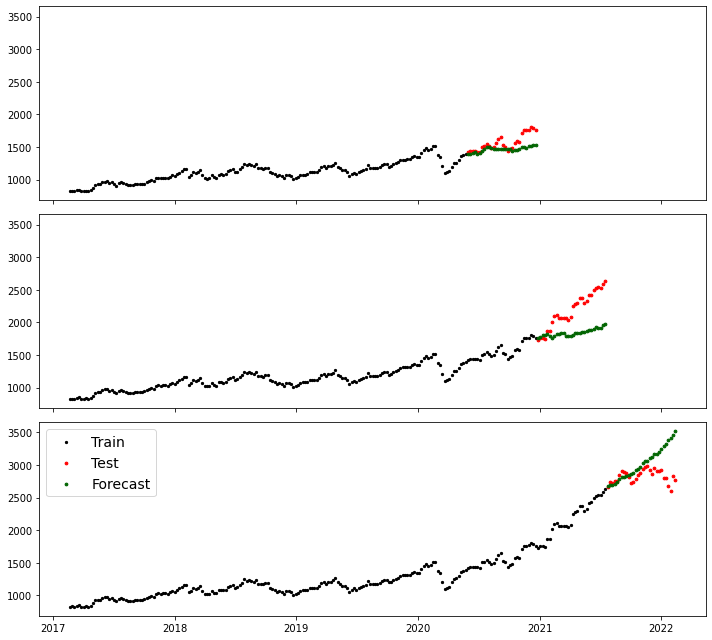

In [58]:
fig, ax_arr = plt.subplots(figsize=[10, 3*N_folds],
                           sharex=True, sharey=True,
                           nrows=N_folds)
for i_fold, (train_index, test_index) in enumerate(tssplit.split(closing_price_week)):
    # modeling
    price_train = closing_price_week.iloc[train_index]
    price_test = closing_price_week.iloc[test_index]
    winter_exp = sm.tsa.ETSModel(price_train, error='add',
                                 trend='mul',seasonal='add').fit(maxiter=200, disp=False)
    price_pred = winter_exp.forecast(steps=test_index.size)
    # visualization
    ax = ax_arr[i_fold]
    ax.scatter(price_train.index, price_train.values,
               marker='.', s=20,
               color='k', label='Train')
    ax.scatter(price_test.index, price_test.values,
               marker='.', s=30,
               color='r', label='Test')
    ax.scatter(price_pred.index, price_pred.values,
               marker='.', s=30,
               color='darkgreen', label='Forecast')
ax.legend(prop={'size': 14})
fig.tight_layout()

---

# Summary

Lastly, let's look back at these models. You may find that the various methods can be reduced into a core question:
- _What kind of components do we want to use to properly model a given time series?_

Hyndman and Athanasopoulos (2018) proposed a two-way classification of exponential smoothing methods in [section 8.4](https://otexts.com/fpp3/taxonomy.html), in which both seasonal and trend components can modelled  _skipped_ ($N$), _additive_ ($A$), or multiplicative ($M$). Furthermore, the trend can be further be modelled as damping ($d$) over time or not.
Nonethelesss, as Hyndman and Athanasopoulos state, they consider multiplicative trend component to be weak in prediction which is excluded from their classification table.
When it comes to application, you can make good use of the [`ETS` API](https://www.statsmodels.org/dev/generated/statsmodels.tsa.exponential_smoothing.ets.ETSModel.html#statsmodels.tsa.exponential_smoothing.ets.ETSModel) and specify the corresponding components according to your own undersatnding about the dataset.

Two last suggestions:

- You are adviced to read more about evaluation metrics of time series on your own. As always, _one size does not fit all_. You may want to choose the proper metric by taking into consideration your use case and your business goal. One of the many resources on this topic can be found [here](https://otexts.com/fpp3/accuracy.html).

- BTW, there is yet another Python package `sktime` written in a similar flavor with `sklearn`. You may find the example applications [here](https://github.com/alan-turing-institute/sktime/blob/f6f2bb94acc1bf35417a56fd46e2bd20e9742d82/examples/01_forecasting.ipynb).

---

# In-Class Exercise

Use the ['AustralianWine.csv'](https://raw.githubusercontent.com/zhiyzuo/IS6400-Regression/main/Data/AustralianWines.csv) with columns `Month` and `Red` and conduct the following exercise. Use the codes in the lecture notes for your reference (please create a new empty Jupyter notebook for this exercise):
1. Visualize the time series using a line plot.
2. Use `statsmodels` to visualize the autocorrelation plot.
3. In combination with the line plot in step 1 and the KPSS test, explain whether this time series is stationary or not.
4. Use the Holt-Winter's method to forecast.
    - Think about what kind of trend/seasonality you want to use bsaed on the previous data exploration.
    - Use fixed partition such that the training consists of 90% of the time and the testing set. Visualize the outcome:
        1. Observed and predicted time series.
        2. Forecast errors in both training and testing samples.

---

# Reference

- Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: principles and practice. OTexts.
- Shmueli, G., & Lichtendahl Jr, K. C. (2016). Practical time series forecasting with R: A hands-on guide. Axelrod schnall publishers.
- STAT 510: Applied Time Series Analytics. https://online.stat.psu.edu/stat510/